In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

# Teachers Prediction:

## 1. Predict bad teacher:
This part of the jupyter's notebook computes different models to predict if a teacher performed bad (least 30 percentile) in the portfolio test based on information we have about their performance in PAA/PSU and GPA.

In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
from scipy import stats
from sklearn import datasets, linear_model, preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree, svm
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LinearRegression

First, let's open the information available to run the models:

In [3]:
df_path = os.getcwd() + '/data/PAA-evdoc.csv'
df = None
#with open(df_path, encoding="utf-16") as f:
with open(df_path, encoding="utf8", errors='ignore') as f:
    df = pd.read_csv(f)

df.head(2)

,periodo,ciclo,subsector,pf_pje,instr_pje,esc_r,Te_EvLevel,proceso,pref,cod,...,DeltaAvePrivado2,Duration,Duration2,DeltaDuration,DeltaDuration2,Type1,Type2,Type3,Type4,_merge
0,2006,2do Ciclo,Matemtica,2.27,2.66,Competente,2,1977,1.0,3537,...,-0.014692,6.0,36.0,1.0,11.0,0,1,0,0,3
1,2006,2do Ciclo,Matemtica,2.27,2.66,Competente,2,1978,3.0,3303,...,NaN,5.0,25.0,NaN,NaN,0,1,0,0,3


Quick df clean:

In [4]:
#Quick df clean:
scores = ['paa_verbal', 'paa_matematica', 'nem', 'gpa', 'pce_hria_y_geografia', 'pce_biologia', 'pce_cs_sociales', 'pce_fisica', 'pce_matematica', 'pce_quimica']
cat = ['region', 'male']
df_s = df[scores].copy()

bygroup = 0
if bygroup == 1:
    df_s['periodo'] = df['periodo']
    df_s = df_s.groupby('periodo').transform(lambda x: (x - x.mean()) / x.std())
else:
    df_s = (df[scores] - df[scores].mean())/df[scores].std()
df_s['Average'] = (df['paa_verbal'] + df['paa_matematica'])/2

df_c = df[cat].copy()

df_s['took_hist'] = (df.pce_hria_y_geografia == 0)
df_s['took_bio'] = (df.pce_biologia == 0)
df_s['took_soc'] = (df.pce_cs_sociales == 0)
df_s['took_fis'] = (df.pce_fisica == 0)
df_s['took_mat'] = (df.pce_matematica == 0)
df_s['took_qui'] = (df.pce_quimica == 0)

y = df['pf_pje']

df = pd.concat([df_s, df_c, y], axis=1)

df = df.dropna()
df.region = df.region.astype(int)
df.male = df.male.astype(int)

#Divide the sample distribution in 10 types:
df['xtile'] = pd.qcut(df.pf_pje, 10, labels = ['percentil: '+str(i) for i in range(10)])
df['worst'] = (df['xtile'] == 'percentil: 0' ) | (df['xtile'] == 'percentil: 1') | (df['xtile'] == 'percentil: 2')

df.columns = ['paaverbal' if x=='paa_verbal' else 'paamat' if x =='paa_matematica' else x for x in df.columns] #Change colname

x_variables = [x if (x!='pf_pje' and x!='xtile' and x!='worst' and x!='region9') else "AAA" for x in list(df)]
x_variables = sorted(list(set(x_variables)))
del x_variables[0]

X_transformed = df[x_variables].dropna().drop(columns = ['region',
'pce_biologia', 'pce_cs_sociales', 'pce_fisica', 'pce_hria_y_geografia', 'pce_matematica', 'pce_quimica'])
#'took_bio', 'took_fis', 'took_hist', 'took_mat', 'took_qui', 'took_soc', 'paamat', 'paaverbal'

X_transformed['paa_avg'] = (X_transformed.Average - X_transformed.Average.mean())/X_transformed.Average.std()
Y = df['worst']      #Here we have the indicator of bad teacher
y_pf = (df['pf_pje'] - df['pf_pje'].mean())/df['pf_pje'].std()  #Here the pf_pje
X_transformed = X_transformed.drop(columns = ['Average', 'paa_avg', 'gpa'])

X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, Y, test_size=0.15)


### 1.1. Likelihood vs teacher performance scatterplot

Define a function which inserts the predictions (predict) and the likelihood (predict_proba) in the main dataframe. One can easily change the model introducing the name of the predictive model in the args.

In [5]:
def gen_predictions(Classifier, X_train, X_test, y_train):
    from sklearn import tree, svm
    SVC = svm.SVC
    if Classifier == SVC:
        clf = Classifier(C=1, probability=True)
    else:
        clf = Classifier()
    clf = clf.fit(X_train, y_train)

    y_test_hat = clf.predict_proba(X_test)[:,1]  #Prob of bad Teacher
    y_test_predict = clf.predict(X_test)  #Prob of bad Teacher

    ndf = y_test_hat.shape[0]
    df_ml_test = X_test.copy()
    df_ml_test['y_test_hat'] = y_test_hat
    df_ml_test = df_ml_test.sort_values(by = ['y_test_hat'])

    return df_ml_test, clf.predict_proba(X_test), y_test_predict

In [6]:
df_rf_test , y_test_hat, y_test_predict = gen_predictions(RandomForestClassifier, X_train_transformed, X_test_transformed, y_train)

In [7]:
accuracy = np.mean(y_test_predict == y_test)
type1_error = 1 - np.mean(y_test[y_test==1] == y_test_predict[y_test==1]) #Type 1 error: Probabilidad de predecir que no es malo cuando si lo es
type2_error = 1 - np.mean(y_test[y_test_predict == 1] == y_test_predict[y_test_predict == 1]) #probabilidad de predecir que profesor es malo cuando en realidad es bueno (Error tipo 2)

print("Overall Accuracy: %.2f \nType 1 error: %.2f \nType 2 error:  %.2f" % (accuracy, type1_error, type2_error))


Overall Accuracy: 0.90 
Type 1 error: 0.23 
Type 2 error:  0.10


Plot Results of the Model. In this case we are using Random forest Estimation

#### Graph 1.1: Likelihood vs PAA Math

Text(0.5,0,'PAA Math')

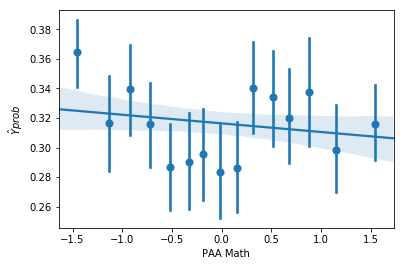

In [8]:
sns.regplot(df_rf_test.paamat, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Math')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_paa_mat.pdf', bbox_inches='tight')

#### Graph 1.2: Likelihood vs PAA Verbal

Text(0.5,0,'PAA Verbal')

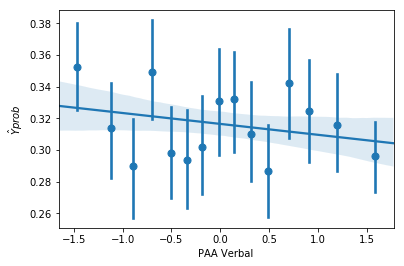

In [9]:
sns.regplot(df_rf_test.paaverbal, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Verbal')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_paa_verbal.pdf', bbox_inches='tight')

#### Graph 1.3: Likelihood vs PAA Average

Text(0.5,0,'PAA Average')

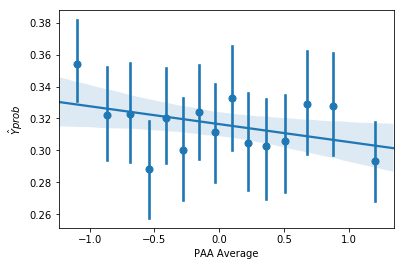

In [10]:
df_rf_test['paa_avg'] = (df_rf_test.paaverbal + df_rf_test.paamat)/2
sns.regplot(df_rf_test.paa_avg, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Average')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_paa_avg.pdf', bbox_inches='tight')

#### Graph 1.4: Likelihood vs GPA

Text(0.5,0,'GPA')

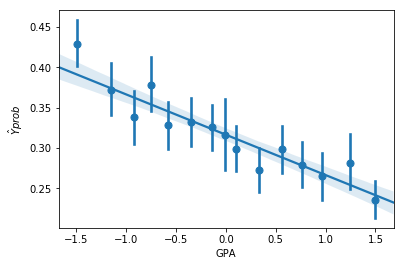

In [11]:
sns.regplot(df_rf_test.nem, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('GPA')
#plt.savefig(r'C:\\Users\\Franco\\GitHub\\teacher-predictions\\output\\Pr_vs_gpa.pdf', bbox_inches='tight')

### 1.2. Sensitivity Analysis

#### Graph 1.5: Accuracy of the model by each level likelihood

Text(0,0.5,'Accuracy: 1 - Pr(failure)')

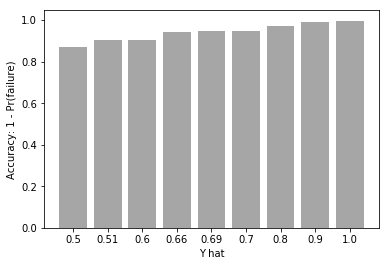

In [12]:
accuracy_list = []
pr_list = list(np.unique(y_test_hat[:,1][y_test_hat[:,1]>=.5]))
for pr in pr_list:
    acc = np.mean(y_test[y_test_hat[:,1]>=pr] == y_test_predict[y_test_hat[:,1]>=pr])
    accuracy_list.append(acc)

ticks = np.arange(len(accuracy_list))
pr_list = [round(x, 2) for x in pr_list]
ticks_label = [str(x) for x in pr_list]

plt.bar(ticks,accuracy_list, align='center', alpha=0.7, color = 'gray')
plt.xticks(ticks, ticks_label)
plt.xlabel('Y hat')
plt.ylabel('Accuracy: 1 - Pr(failure)')
#plt.savefig(r'D:\\Google Drive\\Teacher Quality\\4. Work\\Prediction\\Appendix\\accuracy.pdf', bbox_inches='tight')

### 1.3. Cross Validation

In [13]:
from sklearn import tree, svm
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#CrossValidation Excercise Accuracy tests:
accuracy_type2_rf = []
accuracy_overall_rf = []

accuracy_type2_dt = []
accuracy_overall_dt = []

accuracy_type2_svc = []
accuracy_overall_svc = []

accuracy_type2_lr = []
accuracy_overall_lr = []

# Cross Validate

for i in range(10):

    X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, Y, test_size=0.15)

    clf = RandomForestClassifier()
    clf = clf.fit(X_train_transformed, y_train)
    y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_rf.append(acc_overall)
    accuracy_type2_rf.append(acc_type2)

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train_transformed, y_train)
    y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_dt.append(acc_overall)
    accuracy_type2_dt.append(acc_type2)

    clf = LogisticRegression()
    clf = clf.fit(X_train_transformed, y_train)
    y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_lr.append(acc_overall)
    accuracy_type2_lr.append(acc_type2)
    
    if (i+1)%50 == 0:
        print(f"Crosvalidation: {i}")


#### Graph 1.6: Cross Validation Random Forest

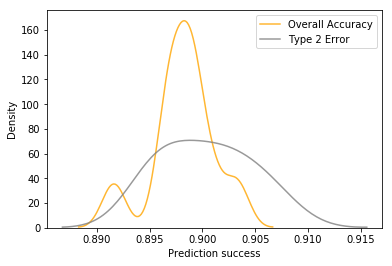

In [14]:
sns.kdeplot(accuracy_overall_rf, alpha=0.8, color = 'orange', label = 'Overall Accuracy')
sns.kdeplot(accuracy_type2_rf, alpha=0.8, color = 'gray', label = 'Type 2 Error')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.legend(loc=1)

#### Graph 1.7: Cross Validation Random Forest vs Decision Tree

<function matplotlib.pyplot.show>

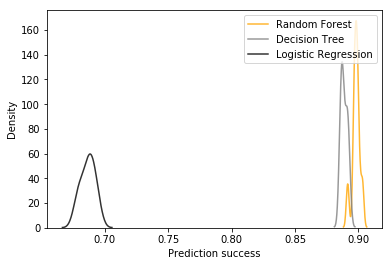

In [15]:
sns.kdeplot(accuracy_overall_rf, alpha=0.8, color = 'orange', label = 'Random Forest')
sns.kdeplot(accuracy_overall_dt, alpha=0.8, color = 'gray', label = 'Decision Tree')
sns.kdeplot(accuracy_overall_lr, alpha=0.8, color = 'black', label = 'Logistic Regression')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.legend(loc=1)
plt.show

#### Graph 1.8: Cross Validation RF vs DT (type 2 error)

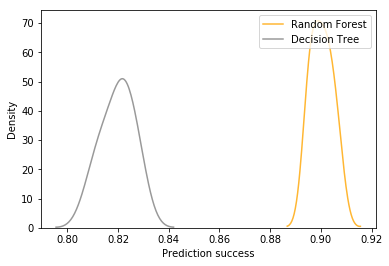

In [16]:
sns.kdeplot(accuracy_type2_rf, alpha=0.8, color = 'orange', label = 'Random Forest')
sns.kdeplot(accuracy_type2_dt, alpha=0.8, color = 'gray', label = 'Decision Tree')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.legend(loc=1)
plt.show()

### 1.4. Get importance of the variables of the best model

In [17]:
clf = RandomForestClassifier()
clf = clf.fit(X_train_transformed, y_train)
y_test_hat = clf.predict(X_test_transformed)  #Prob of bad Teacher
acc_overall = np.mean(y_test == y_test_hat)
acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
accuracy_overall_rf.append(acc_overall)
accuracy_type2_rf.append(acc_type2)

importance = clf.feature_importances_
FeatImp = {}

feature_list = list(X_train_transformed.columns)

for x in range(0,len(feature_list)):
    if importance[x]>0:
        FeatImp[feature_list[x]]=importance[x]
        
s = [(k, FeatImp[k]) for k in sorted(FeatImp, key=FeatImp.get, reverse=True)]
for item in s:
    print(item)

('paaverbal', 0.3230873056539488)
('paamat', 0.31330577457346875)
('nem', 0.24341021393831355)
('took_hist', 0.02260489902900057)
('took_soc', 0.021878713131917877)
('took_bio', 0.020618258038409474)
('took_mat', 0.01581842118837758)
('took_fis', 0.014748694028452336)
('took_qui', 0.013969945000959282)
('male', 0.010557775417151812)


#### Graph 1.9: Contribution of each feature to the prediction

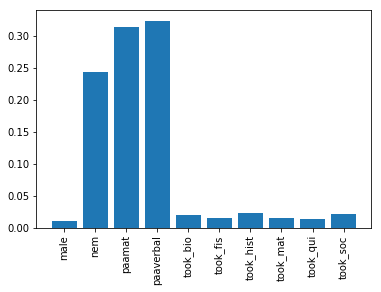

In [18]:
plt.bar(range(len(FeatImp)), list(FeatImp.values()), align='center')
plt.xticks(range(len(FeatImp)), list(FeatImp.keys()), rotation='vertical')
plt.show()

### 1.4. Prediction of the portfolio score

In [19]:
from sklearn import linear_model
from sklearn.metrics import r2_score

#### Graph 1.10: Portfolio vs PAA - Math

Text(0.5,0,'PAA - Mathematics')

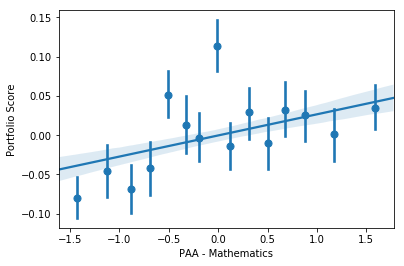

In [20]:
sns.regplot(X_transformed.paamat, y_pf, x_bins = 15)
plt.ylabel(r'Portfolio Score')
plt.xlabel('PAA - Mathematics')

#### Graph 1.11: Portfolio vs PAA - Verbal

Text(0.5,0,'PAA - Verbal')

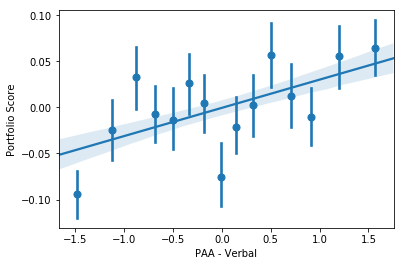

In [21]:
sns.regplot(X_transformed.paaverbal, y_pf, x_bins = 15)
plt.ylabel(r'Portfolio Score')
plt.xlabel('PAA - Verbal')

#### Graph 1.12: Portfolio vs GPA

Text(0.5,0,'GPA')

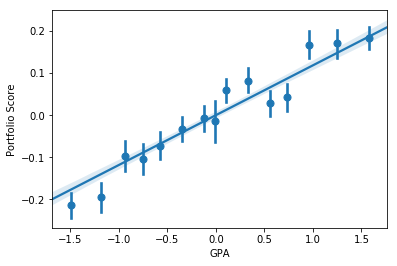

In [22]:
sns.regplot(X_transformed.nem, y_pf, x_bins = 15)
plt.ylabel(r'Portfolio Score')
plt.xlabel('GPA')

In [23]:
X_train_transformed, X_test_transformed, y_train, y_test = train_test_split(X_transformed, y_pf, test_size=0.25)

clf = linear_model.LinearRegression()
clf.fit(X_train_transformed, y_train)
pred_train_lr = clf.predict(X_train_transformed)
pred_test_lr = clf.predict(X_test_transformed)
ls_r = clf.score(X_test_transformed, y_test)

clf = linear_model.RidgeCV()
clf.fit(X_train_transformed, y_train)
pred_train_rd = clf.predict(X_train_transformed)
pred_test_rd = clf.predict(X_test_transformed)
clf.score(X_train_transformed, y_train)
rcv_r = clf.score(X_test_transformed, y_test)

clf = linear_model.Lasso(alpha = 0.1)
clf.fit(X_train_transformed, y_train)
pred_train_la = clf.predict(X_train_transformed)
pred_test_la = clf.predict(X_test_transformed)
clf.score(X_train_transformed, y_train)
lasso_r = clf.score(X_test_transformed, y_test)

In [24]:
print("OLS R2: %.4f \nRidge R2: %.4f \nLasso R2:  %.4f" % (ls_r, rcv_r, lasso_r))


OLS R2: 0.0148 
Ridge R2: 0.0148 
Lasso R2:  0.0041


#### Graph 1.13: Predicted portfolio (OLS) vs portfolio

(-0.3, 0.3)

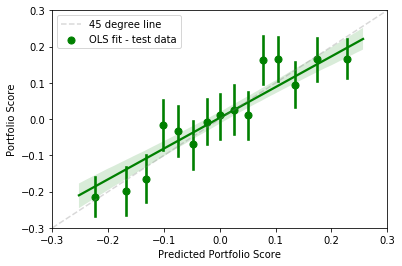

In [47]:
sns.regplot(pred_test_lr, y_test, x_bins = 15, color='g', label='OLS fit - test data')
plt.plot(np.array(np.linspace(-.3, .3, num=5)), np.array(np.linspace(-.3, .3, num=5)), color='gray',alpha=.3,linestyle='--', label='45 degree line')
plt.ylabel(r'Portfolio Score')
plt.xlabel('Predicted Portfolio Score')
plt.legend()
ax = plt.gca()
ax.set_ylim([-.3, .3])
ax.set_xlim([-.3, .3])

#### Graph 1.14: Predicted portfolio (Ridge) vs portfolio

(-0.3, 0.3)

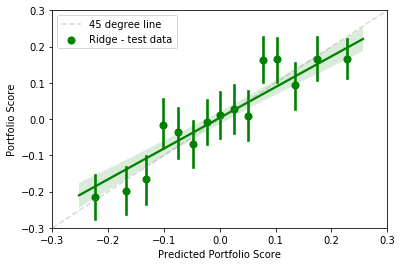

In [48]:
sns.regplot(pred_test_rd, y_test, x_bins = 15, color='g', label='Ridge - test data')
plt.plot(np.array(np.linspace(-.3, .3, num=5)), np.array(np.linspace(-.3, .3, num=5)), color='gray', alpha = 0.3, linestyle='--', label='45 degree line')
plt.ylabel(r'Portfolio Score')
plt.xlabel('Predicted Portfolio Score')
plt.legend()
ax = plt.gca()
ax.set_ylim([-.3, .3])
ax.set_xlim([-.3, .3])

## 2. Predict probability of work as teacher:
This part of the jupyter's notebook computes different models to predict if a student, given their characteristics is going to be a teacher in the future. 

In [ ]:
df_path = os.getcwd() + '/data/proceso_evdoc.csv'
df = None
#with open(df_path, encoding="utf-16") as f:
with open(df_path, "r") as f:
    df = pd.read_csv(f)

df.head(2)

In [ ]:
tests = ['pce_fisica', 'pce_quimica', 'pce_biologia', 'pce_matematica', 'pce_cs_sociales', 'pce_hria_y_geografia']
for test in tests:
    df['took_'+str(test)] = (df[test]==0)


scores = ['nem', 'paa_verbal', 'paa_matematica', 'pce_fisica', 'pce_quimica', 'pce_biologia', 'pce_matematica', 'pce_cs_sociales', 'pce_hria_y_geografia']
df[scores] = (df[scores] - df[scores].mean())/df[scores].std()

df.head(1)
vars = ['proceso', 'nem', 'paa_verbal', 'paa_matematica', 'pce_fisica', 'pce_quimica', 'pce_biologia', 'pce_matematica', 'pce_cs_sociales', 'pce_hria_y_geografia', 'took_pce_fisica', 'took_pce_quimica', 'took_pce_biologia', 'took_pce_matematica', 'took_pce_cs_sociales', 'took_pce_hria_y_geografia', 'fl_teacher', 'isteacher']
indepvars = vars[:-2]
depvar = vars[-2]
depvar2 = vars[-1]

teacher_2 = 1   #Activate this when we want to predict if the student is a prefesor given that his/her fl is 1
if teacher_2 == 1:
    df = df[vars][df['fl_teacher']==1].dropna()
    Y = df[depvar2]
else:
    df = df[vars].dropna()
    Y = df[depvar]

X = df[indepvars]

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

### 2.1. Likelihood of being teacher vs undergrad performance scatterplot

In [ ]:
df_rf_test , y_test_hat, y_test_predict = gen_predictions(RandomForestClassifier, X_train, X_test, y_train)

In [ ]:
y_test.mean()
y_test_predict.mean()
#Accuracy tests:
accuracy = np.mean(y_test_predict == y_test)
type1_error = np.mean(y_test[y_test==1] == y_test_predict[y_test==1]) #Type 1 error: Probabilidad acierto cuando es profesor
type2_error = np.mean(y_test[y_test_predict == 1] == y_test_predict[y_test_predict == 1]) #probabilidad de predecir que es profesor

In [ ]:
print("Overall Accuracy: %.2f \nType 1 error: %.2f \nType 2 error:  %.2f" % (accuracy, type1_error, type2_error))

#### Graph 2.1: Likelihood vs PAA Math

In [ ]:
sns.regplot(df_rf_test.paa_matematica, df_rf_test.y_test_hat, x_bins = 25)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Math')
plt.show()

#### Graph 2.2: Likelihood vs PAA Verbal

In [ ]:
sns.regplot(df_rf_test.paa_verbal, df_rf_test.y_test_hat, order =2 , x_bins = 25)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('PAA Verbal')
plt.show()

#### Graph 2.3: Likelihood vs GPA

In [ ]:
sns.regplot(df_rf_test.nem, df_rf_test.y_test_hat, x_bins = 15)
plt.ylabel(r'$\^Yprob$')
plt.xlabel('GPA Score')
plt.show()

### 2.2. Sensitivity Analysis

#### Graph 2.4: Accuracy of the model by each level likelihood

In [ ]:
accuracy_list = []
pr_list = list(np.unique(y_test_hat[:,1][y_test_hat[:,1]>=.5]))
for pr in pr_list:
    acc = np.mean(y_test[y_test_hat[:,1]>=pr] == y_test_predict[y_test_hat[:,1]>=pr])
    accuracy_list.append(acc)

ticks = np.arange(len(accuracy_list))
pr_list = [round(x, 2) for x in pr_list]
ticks_label = [str(x) for x in pr_list]

plt.bar(ticks,accuracy_list, align='center', alpha=0.7, color = 'gray')
plt.xticks(ticks, ticks_label)
plt.xlabel('Y hat')
plt.ylabel('Accuracy: 1 - Pr(failure)')
plt.title('Likelihood of success when predicting that a student will become a teacher')

### 2.3. Cross Validation

In [ ]:
accuracy_type2_rf = []
accuracy_overall_rf = []

accuracy_type2_dt = []
accuracy_overall_dt = []

accuracy_type2_lr = []
accuracy_overall_lr = []

for i in range(150):

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.15)

    clf = RandomForestClassifier()
    clf = clf.fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)  #Prob of being teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_rf.append(acc_overall)
    accuracy_type2_rf.append(acc_type2)

    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)  #Prob of being Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_dt.append(acc_overall)
    accuracy_type2_dt.append(acc_type2)

    clf = LogisticRegression()
    clf = clf.fit(X_train, y_train)
    y_test_hat = clf.predict(X_test)  #Prob of being Teacher
    acc_overall = np.mean(y_test == y_test_hat)
    acc_type2 = np.mean(y_test[y_test_hat==1] == y_test_hat[y_test_hat==1])
    accuracy_overall_lr.append(acc_overall)
    accuracy_type2_lr.append(acc_type2)

    if (i+1)%50 == 0:
        print(f"Crossvalidation: {i}")

#### Graph 2.5: Cross Validation LR vs RF

In [ ]:
sns.kdeplot(accuracy_overall_lr, alpha=0.8, color = 'orange', label = 'Logistic Regression')
sns.kdeplot(accuracy_overall_dt, alpha=0.8, color = 'gray', label = 'Decision Tree')
sns.kdeplot(accuracy_overall_rf, alpha=0.8, color = 'black', label = 'Random Forest')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.title('Cross validation: Accuracy of Random Forest')
plt.legend(loc=1)

#### Graph 2.5: Overall Accuracy and Type 2 error of RF

In [ ]:
sns.kdeplot(accuracy_overall_lr, alpha=0.8, color = 'orange', label = 'Logistic Regression')
sns.kdeplot(accuracy_overall_dt, alpha=0.8, color = 'gray', label = 'Decision Tree')
sns.kdeplot(accuracy_overall_rf, alpha=0.8, color = 'gray', label = 'Random Forest')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.title('Cross validation: Accuracy of Random Forest')
plt.legend(loc=1)

In [ ]:
Graph 2.5: Overall Accuracy and Type 2 error of RF

In [ ]:
sns.kdeplot(accuracy_type2_rf, alpha=0.8, color = 'orange', label = 'Random Forest')
sns.kdeplot(accuracy_type2_dt, alpha=0.8, color = 'gray', label = 'Decision Tree')
plt.xlabel('Prediction success')
plt.ylabel('Density')
plt.title('Cross validation: Accuracy of Random Forest')
plt.legend(loc=1)